***Human Activity Recognition With Raw Data (80-20) split***

Current version is 1.15.0, need to install 1.13.1

///   !pip install -q -U tensorflow ==1.13.1

!pip install tensorflow==1.13.1

import tensorflow as tf

print(tf.__version__)

In [69]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import os
os.chdir("/content/drive/My Drive/HAR Dataset/HAR Mine")

In [71]:
!ls "/content/drive/My Drive/HAR Dataset/HAR Mine"

'Additional Testing Code'
'Basic Data'
 checkpoint
 converted_model.tflite
'data visualitaion.ipynb'
'Feature Test.ipynb'
 frozen_har.pb
'HAR get three activities.ipynb'
 history.p
 human_activity_recognition_basic.ipynb
 human_activity_recognition_Classifier.ipynb
'Human Activity Recognition Classifier Result.gsheet'
 Human_activity_recognition_feature_extract.ipynb
 Human_activity_recognition_magnitude_Feature_extract.ipynb
 human_activity_recognition_MINE_2.ipynb
 human_activity_recognition_MINE.ipynb
 human_activity_recognition_with_raw_data.ipynb
 human_activity_recognition_with_raw_data_new_tech.ipynb
 predictions.p
'Processed Data'
'RNN Result.gsheet'
'Subject with number activities performed.gsheet'
 wisdomDataRemoveJoggingActivity.ipynb


In [72]:
!pip install tensorflow==1.13.1

#import tensorflow as tf
#print(tf.version)

# Load Library

In [0]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy import stats
import tensorflow as tf
import seaborn as sns
from pylab import rcParams
from sklearn import metrics
from sklearn.model_selection import train_test_split

%matplotlib inline

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 14, 8

RANDOM_SEED = 42

In [76]:
print(tf.__version__)

1.13.1


# Load Data

In [0]:
columns = ['x','y','z', 'timestamp_ms', 'subject_id', 'class', "timestamp_ms"]


#df = pd.read_csv('Basic Data/accelerometer_data_merged_all.csv')
#df = pd.read_csv('Basic Data/accelerometer_data_merged_three_activities.csv')
df = pd.read_csv('Basic Data/Three_activities_data.csv')
df = df.dropna()

In [78]:
df.head()

,x,y,z,timestamp_ms,subject_id,class,timestamp_s
0,1.249481,12.565552,-0.324005,1.560000e+12,1,WALKING,1563706524
1,0.253494,14.217560,2.783661,1.560000e+12,1,WALKING,1563706524
2,0.504883,13.774628,2.587341,1.560000e+12,1,WALKING,1563706524
3,1.180054,12.532043,-0.027130,1.560000e+12,1,WALKING,1563706524
4,0.725159,12.230362,-0.292892,1.560000e+12,1,WALKING,1563706524


In [79]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 212577 entries, 0 to 212576
Data columns (total 7 columns):
x               212577 non-null float64
y               212577 non-null float64
z               212577 non-null float64
timestamp_ms    212577 non-null float64
subject_id      212577 non-null int64
class           212577 non-null object
timestamp_s     212577 non-null int64
dtypes: float64(4), int64(2), object(1)
memory usage: 13.0+ MB


In [0]:
#df = df.sample(frac=1)
#df = df.sample(frac=1).reset_index(drop=True)

In [81]:
df.head()

,x,y,z,timestamp_ms,subject_id,class,timestamp_s
0,1.249481,12.565552,-0.324005,1.560000e+12,1,WALKING,1563706524
1,0.253494,14.217560,2.783661,1.560000e+12,1,WALKING,1563706524
2,0.504883,13.774628,2.587341,1.560000e+12,1,WALKING,1563706524
3,1.180054,12.532043,-0.027130,1.560000e+12,1,WALKING,1563706524
4,0.725159,12.230362,-0.292892,1.560000e+12,1,WALKING,1563706524


# Pre process data

In [0]:
N_TIME_STEPS = 200
N_FEATURES = 3
step = 20
segments = []
labels = []
for i in range(0, len(df) - N_TIME_STEPS, step):
    xs = df['x'].values[i: i + N_TIME_STEPS]
    ys = df['y'].values[i: i + N_TIME_STEPS]
    zs = df['z'].values[i: i + N_TIME_STEPS]
    label = stats.mode(df['class'][i: i + N_TIME_STEPS])[0][0]
    segments.append([xs, ys, zs])
    labels.append(label)

In [83]:
np.array(segments).shape

(10619, 3, 200)

In [0]:
reshaped_segments = np.asarray(segments, dtype= np.float32).reshape(-1, N_TIME_STEPS, N_FEATURES)
labels = np.asarray(pd.get_dummies(labels), dtype = np.float32)

In [85]:
reshaped_segments.shape

(10619, 200, 3)

In [86]:
labels[0]

array([0., 0., 1.], dtype=float32)

In [0]:
X_train, X_test, y_train, y_test = train_test_split(
        reshaped_segments, labels, test_size=0.2, random_state=RANDOM_SEED)

In [88]:
len(X_train)

8495

In [89]:
len(X_test)

2124

# Building the model

Our model contains 2 fully-connected and 2 LSTM layers (stacked on each other) with 64 units each:

In [0]:
N_CLASSES = 3
N_HIDDEN_UNITS = 64

In [0]:
def create_LSTM_model(inputs):
    W = {
        'hidden': tf.Variable(tf.random_normal([N_FEATURES, N_HIDDEN_UNITS])),
        'output': tf.Variable(tf.random_normal([N_HIDDEN_UNITS, N_CLASSES]))
    }
    biases = {
        'hidden': tf.Variable(tf.random_normal([N_HIDDEN_UNITS], mean=1.0)),
        'output': tf.Variable(tf.random_normal([N_CLASSES]))
    }
    
    X = tf.transpose(inputs, [1, 0, 2])
    X = tf.reshape(X, [-1, N_FEATURES])
    hidden = tf.nn.relu(tf.matmul(X, W['hidden']) + biases['hidden'])
    hidden = tf.split(hidden, N_TIME_STEPS, 0)

    # Stack 2 LSTM layers
    lstm_layers = [tf.contrib.rnn.BasicLSTMCell(N_HIDDEN_UNITS, forget_bias=1.0) for _ in range(2)]
    lstm_layers = tf.contrib.rnn.MultiRNNCell(lstm_layers)

    outputs, _ = tf.contrib.rnn.static_rnn(lstm_layers, hidden, dtype=tf.float32)

    # Get output for the last time step
    lstm_last_output = outputs[-1]

    return tf.matmul(lstm_last_output, W['output']) + biases['output']

Now, let create placeholders for our model:

In [0]:
tf.reset_default_graph()

X = tf.placeholder(tf.float32, [None, N_TIME_STEPS, N_FEATURES], name="input")
Y = tf.placeholder(tf.float32, [None, N_CLASSES])

Note that we named the input tensor, that will be useful when using the model from Android. Creating the model:

In [0]:
#os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
pred_Y = create_LSTM_model(X)

pred_softmax = tf.nn.softmax(pred_Y, name="y_")

In [0]:
L2_LOSS = 0.0015

l2 = L2_LOSS * \
    sum(tf.nn.l2_loss(tf_var) for tf_var in tf.trainable_variables())

loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = pred_Y, labels = Y)) + l2

Finally, let's define optimizer and accuracy ops:

In [0]:
LEARNING_RATE = 0.0025

optimizer = tf.train.AdamOptimizer(learning_rate=LEARNING_RATE).minimize(loss)

correct_pred = tf.equal(tf.argmax(pred_softmax, 1), tf.argmax(Y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, dtype=tf.float32))

# Training

The training part contains a lot of TensorFlow boilerplate. We will train our model for 50 epochs and keep track of accuracy and error:

In [0]:
N_EPOCHS = 50
BATCH_SIZE = 256

In [98]:
saver = tf.train.Saver()

history = dict(train_loss=[], 
                     train_acc=[], 
                     test_loss=[], 
                     test_acc=[])

sess=tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

train_count = len(X_train)

for i in range(1, N_EPOCHS + 1):
    for start, end in zip(range(0, train_count, BATCH_SIZE),
                          range(BATCH_SIZE, train_count + 1,BATCH_SIZE)):
        sess.run(optimizer, feed_dict={X: X_train[start:end],
                                       Y: y_train[start:end]})

    _, acc_train, loss_train = sess.run([pred_softmax, accuracy, loss], feed_dict={
                                            X: X_train, Y: y_train})

    _, acc_test, loss_test = sess.run([pred_softmax, accuracy, loss], feed_dict={
                                            X: X_test, Y: y_test})

    history['train_loss'].append(loss_train)
    history['train_acc'].append(acc_train)
    history['test_loss'].append(loss_test)
    history['test_acc'].append(acc_test)

    print(f'epoch: {i} test accuracy: {acc_test} loss: {loss_test}')
    
predictions, acc_final, loss_final = sess.run([pred_softmax, accuracy, loss], feed_dict={X: X_test, Y: y_test})

print()
print(f'final results: accuracy: {acc_final} loss: {loss_final}')

epoch: 1 test accuracy: 0.9722222089767456 loss: 0.6359208822250366
epoch: 2 test accuracy: 0.9877589344978333 loss: 0.5538876056671143
epoch: 3 test accuracy: 0.9891713857650757 loss: 0.5206496119499207
epoch: 4 test accuracy: 0.9872881174087524 loss: 0.47999322414398193
epoch: 5 test accuracy: 0.9882297515869141 loss: 0.4542180597782135
epoch: 6 test accuracy: 0.9887005686759949 loss: 0.4288703203201294
epoch: 7 test accuracy: 0.9887005686759949 loss: 0.4068427085876465
epoch: 8 test accuracy: 0.9811676144599915 loss: 0.4110378623008728
epoch: 9 test accuracy: 0.9844632744789124 loss: 0.3811268210411072
epoch: 10 test accuracy: 0.9905837774276733 loss: 0.35476720333099365
epoch: 11 test accuracy: 0.9910545945167542 loss: 0.33038341999053955
epoch: 12 test accuracy: 0.9891713857650757 loss: 0.3252826929092407
epoch: 13 test accuracy: 0.9882297515869141 loss: 0.3254023492336273
epoch: 14 test accuracy: 0.9896422028541565 loss: 0.30256572365760803
epoch: 15 test accuracy: 0.991054594516

In [99]:
from sklearn import preprocessing
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support

data = df.values
print(len(data), len(df), data.shape)
le = preprocessing.LabelEncoder()
y = le.fit_transform(data[:, -2].astype('str'))+1

subjects = np.unique(df['subject_id'])
print(subjects)

activity_ids = np.unique(y)
n_class = len(activity_ids)
print(activity_ids)

212577 212577 (212577, 7)
[1 2 3 4 5 6 7 8]
[1 2 3]


In [100]:
print(activity_ids)
activity_ids = np.unique(y)-1
print(activity_ids)

[1 2 3]
[0 1 2]


In [0]:
def classification_report(cm):

  true_pos = np.diag(cm)
  false_pos = np.sum(cm, axis=0) - true_pos
  false_neg = np.sum(cm, axis=1) - true_pos

  precision = true_pos / (true_pos+false_pos)
  recall = true_pos / (true_pos + false_neg)
  
  f1_score = 2/(precision**-1 + recall**-1)
  return precision, recall, f1_score

<class 'numpy.ndarray'> (2124, 3) [0. 0. 1.]
<class 'numpy.ndarray'> (2124,) 2
[2 2 2 ... 2 0 0]
<class 'numpy.ndarray'> (2124,) [2 2 2 ... 2 0 0]
accuracy  0.9919962335216572
precision, recall, f1score, accuracy
0.9920398515285478 0.9919962335216572 0.9919741622539902 0.9919962335216572
class-wise precision: [0.98902606 0.99065421 0.99690402]
class-wise recall: [0.99861496 0.9986541  0.97723824]
class-wise f1score: [0.99379738 0.99463807 0.98697318]
class-wise accuracy: [0.99861496 0.9986541  0.97723824]
[[721   0   1]
 [  0 742   1]
 [  8   7 644]]


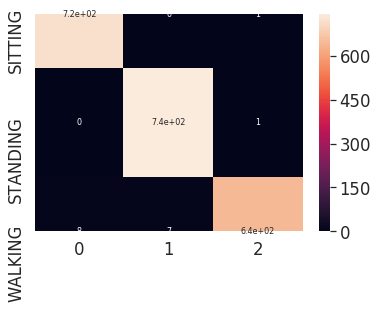

In [102]:
import seaborn as sn

%matplotlib inline
print(type(y_test), y_test.shape, y_test[0])

test_y = np.argmax(y_test, axis=1)
print(type(test_y), test_y.shape, test_y[0])
print(test_y)



#print(predictions)
#print(type(predictions), predictions.shape, predictions[0])
l= np.argmax(predictions, axis=1)
#print (type(l), l.shape, l)
#print (type(l), l.shape)

pred = activity_ids[np.argmax(predictions, axis=1)]
print(type(pred),pred.shape, pred)


acc = accuracy_score(test_y, pred)

precision, recall, f1score, _ = precision_recall_fscore_support(test_y, pred, average='weighted')
print('accuracy ', acc)
print("precision, recall, f1score, accuracy")
print( precision,recall,f1score,acc)

#print ( ">>> ", type(test_y),test_y.shape, type(pred), pred.shape)

cm_all = confusion_matrix(test_y, pred)

class_prec, class_rec, class_f1 = classification_report(cm_all)
class_acc = cm_all.diagonal()/np.sum(cm_all, axis=1)
print('class-wise precision:',class_prec)
print('class-wise recall:',class_rec)
print('class-wise f1score:',class_f1)
print('class-wise accuracy:',class_acc)

print(cm_all.astype('int'))

#array = confusion_matrix(true_all, pred_all)
array = confusion_matrix(test_y, pred)
#df_cm = pd.DataFrame(array, range(5),range(5))
df_cm = pd.DataFrame(array, range(3),range(3))
#sn.set(font_scale=1)#for label size
#sn.heatmap(df_cm, annot=True,annot_kws={"size": 8},yticklabels=('SITTING', 'STANDING', 'WALKING', 'WALKING_DOWNSTAIRS', 'WALKING_UPSTAIRS'))# font size
sn.heatmap(df_cm, annot=True,annot_kws={"size": 8},yticklabels=('SITTING', 'STANDING', 'WALKING'))

plt.show()


Whew, that was a lot of training. Do you feel thirsty? Let's store our precious model to disk:

In [0]:
pickle.dump(predictions, open("predictions.p", "wb"))
pickle.dump(history, open("history.p", "wb"))



In [104]:
#tf.train.write_graph(sess.graph_def, '.', './checkpoint/har.pbtxt')  
#saver.save(sess, save_path = "./checkpoint/har.ckpt")

tf.train.write_graph(sess.graph_def, '.', 'checkpoint/har.pbtxt')  
saver.save(sess, save_path = "checkpoint/har.ckpt")

'checkpoint/har.ckpt'

In [0]:
sess.close()

And loading it back:

In [0]:
history = pickle.load(open("history.p", "rb"))
predictions = pickle.load(open("predictions.p", "rb"))

# Evaluation

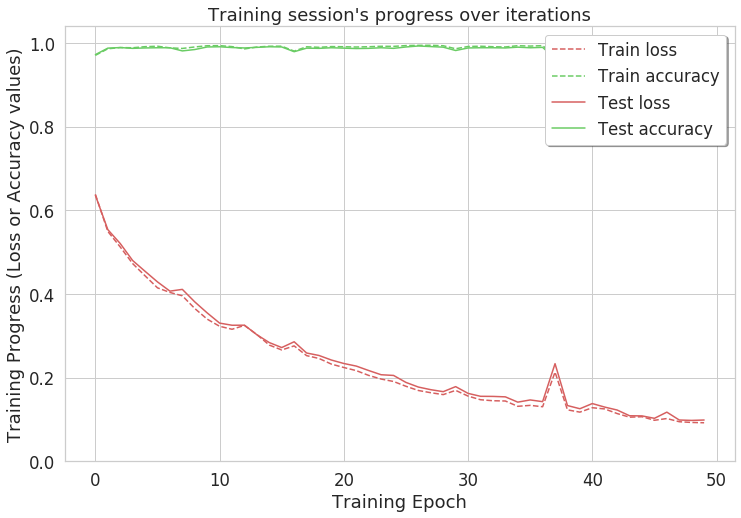

In [107]:
plt.figure(figsize=(12, 8))

plt.plot(np.array(history['train_loss']), "r--", label="Train loss")
plt.plot(np.array(history['train_acc']), "g--", label="Train accuracy")

plt.plot(np.array(history['test_loss']), "r-", label="Test loss")
plt.plot(np.array(history['test_acc']), "g-", label="Test accuracy")

plt.title("Training session's progress over iterations")
plt.legend(loc='upper right', shadow=True)
plt.ylabel('Training Progress (Loss or Accuracy values)')
plt.xlabel('Training Epoch')
plt.ylim(0)

plt.show()

Our model seems to learn well with accuracy reaching above 97% and loss hovering at around 0.2. Let's have a look at the confusion matrix for the model's predictions:

In [0]:
LABELS = ['SITTING', 'STANDING', 'WALKING']

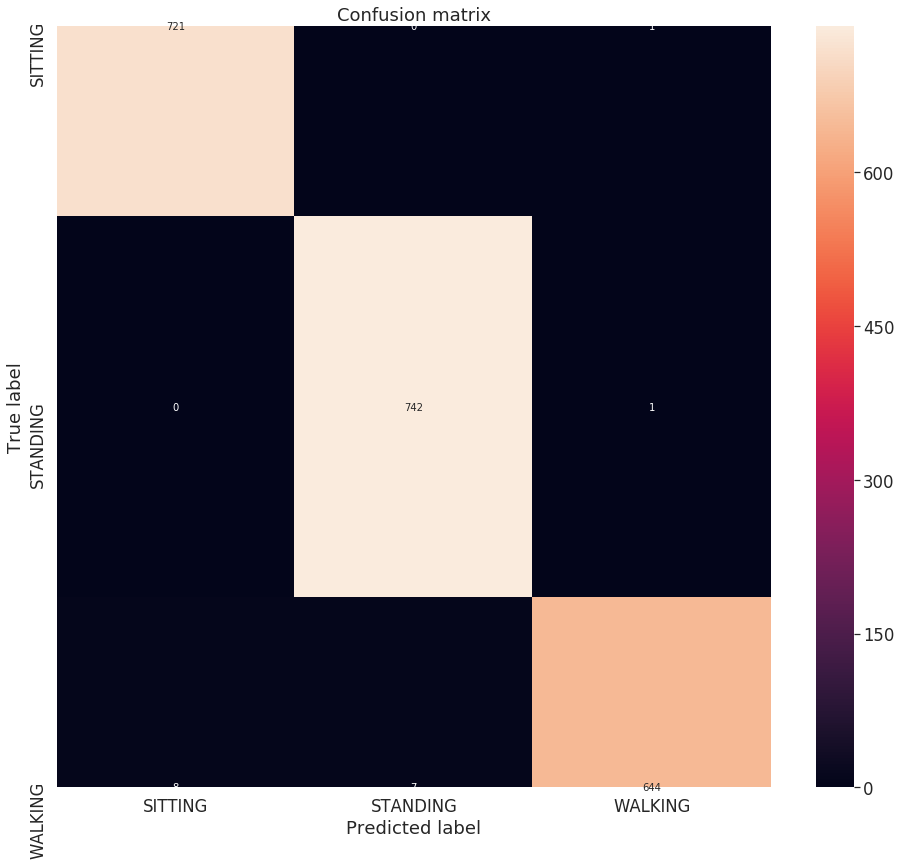

In [109]:
max_test = np.argmax(y_test, axis=1)
max_predictions = np.argmax(predictions, axis=1)
confusion_matrix = metrics.confusion_matrix(max_test, max_predictions)

plt.figure(figsize=(16, 14))
sns.heatmap(confusion_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show();

Again, it looks like our model performs real good. Some notable exceptions include the misclassification of  Upstairs for Downstairs and vice versa. Jogging seems to fail us from time to time as well!

# Exporting the model

Now that most of the hard work is done we must export our model in a way that TensorFlow for Android will understand it:

In [110]:
from tensorflow.python.tools import freeze_graph

#MODEL_NAME = 'har'
MODEL_NAME = 'har'

input_graph_path = 'checkpoint/' + MODEL_NAME+'.pbtxt'
checkpoint_path = './checkpoint/' +MODEL_NAME+'.ckpt'
restore_op_name = "save/restore_all"
filename_tensor_name = "save/Const:0"
output_frozen_graph_name = 'frozen_'+MODEL_NAME+'.pb'
#output_frozen_graph_name = 'frozen_model_new2'+'.pb'

freeze_graph.freeze_graph(input_graph_path, input_saver="",
                          input_binary=False, input_checkpoint=checkpoint_path, 
                          output_node_names="y_", restore_op_name="save/restore_all",
                          filename_tensor_name="save/Const:0", 
                          output_graph=output_frozen_graph_name, clear_devices=True, initializer_nodes="")

INFO:tensorflow:Restoring parameters from ./checkpoint/har.ckpt
INFO:tensorflow:Froze 8 variables.
INFO:tensorflow:Converted 8 variables to const ops.


#convert to tflite model

In [111]:
# tensprflow cpu VERSION 1.13.1
# print(tf.__version__)

graph_def_file = 'frozen_'+MODEL_NAME+'.pb'
#graph_def_file = "frozen_model_new2.pb"
input_arrays = ["input"]
output_arrays = ["y_"]

converter = tf.lite.TFLiteConverter.from_frozen_graph(
  graph_def_file, input_arrays, output_arrays)
tflite_model = converter.convert()
open("converted_model_raw.tflite", "wb").write(tflite_model)

1398724

In [112]:

# Check the converted TensorFlow Lite model.
interpreter = tf.lite.Interpreter(model_content=tflite_model)

try:
  interpreter.allocate_tensors()
except ValueError:
  assert False

MINI_BATCH_SIZE = 1
correct_case = 0
for i in range(len(X_test)):
  input_index = (interpreter.get_input_details()[0]['index'])
  interpreter.set_tensor(input_index, X_test[i * MINI_BATCH_SIZE: (i + 1) * MINI_BATCH_SIZE])
  interpreter.invoke()
  output_index = (interpreter.get_output_details()[0]['index'])
  result = interpreter.get_tensor(output_index)
  # Reset all variables so it will not pollute other inferences.
  interpreter.reset_all_variables()
  # Evaluate.
  #print(result)
  prediction = np.argmax(result)
  #print(prediction, y_test[i],np.argmax(y_test[i]))
  if prediction == np.argmax(y_test[i]):
    correct_case += 1
#print (correct_case)
print('TensorFlow Lite Evaluation result is {}'.format(correct_case * 1.0 / len(X_test)))

TensorFlow Lite Evaluation result is 0.9919962335216572


A sample app that uses the exported model can be found on [GitHub](https://github.com/curiousily/TensorFlow-on-Android-for-Human-Activity-Recognition-with-LSTMs/tree/master/AndroidApp). It is based heavily based on the [Activity Recognition](https://github.com/aqibsaeed/Human-Activity-Recognition-using-CNN/tree/master/ActivityRecognition) app by [Aaqib Saeed](https://aqibsaeed.github.io/). Our app uses the text-to-speech Android API to tell you what the model predicts at some interval and includes our pre-trained model.

The most notable parts of the Java code include defining our input and output dimensions and names:

```java
String INPUT_NODE = "inputs";
String[] OUTPUT_NODES = {"y_"};
String OUTPUT_NODE = "y_";
long[] INPUT_SIZE = {1, 200, 3};
int OUTPUT_SIZE = 6;
```

Creating the TensorFlowInferenceInterface:

```java
inferenceInterface = new TensorFlowInferenceInterface(context.getAssets(), MODEL_FILE);
```

And making the predictions:

```java
public float[] predictProbabilities(float[] data) {
    float[] result = new float[OUTPUT_SIZE];
    inferenceInterface.feed(INPUT_NODE, data, INPUT_SIZE);
    inferenceInterface.run(OUTPUT_NODES);
    inferenceInterface.fetch(OUTPUT_NODE, result);

    //Downstairs	Jogging	  Sitting	Standing	Upstairs	Walking
    return result;
}
```

The result is a float array that contains the probability for each possible activity, according to our model.

# Conclusion

We've built an LSTM model that can predict human activity from 200 time-step sequence with over 97% accuracy on the test set. The model was exported and used in an Android app. I had a lot of fun testing it on my phone, but it seems like more fine tuning (or changing the dataset) is required. Did you try the app? Can you improve it?

# References

- [CNN for Human Activity Recognition](https://github.com/aqibsaeed/Human-Activity-Recognition-using-CNN)
- [LSTMs for Human Activity Recognition](https://github.com/guillaume-chevalier/LSTM-Human-Activity-Recognition)
- [Activity Recognition using Cell Phone Accelerometers](http://www.cis.fordham.edu/wisdm/public_files/sensorKDD-2010.pdf)
- [WIreless Sensor Data Mining Lab](http://www.cis.fordham.edu/wisdm/dataset.php)